In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer

In [27]:
df = pd.read_csv("../data/cleaned_heart_disease.csv")

In [28]:
X = df.drop("num", axis=1)
Y = df["num"]

### Feature Importance using Random Forest

In [29]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, Y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

In [31]:
print("Random Forest Feature Importances:")
print(feature_importances.sort_values(ascending=False))

Random Forest Feature Importances:
thalach     0.127391
cp          0.124785
ca          0.117404
thal        0.114945
oldpeak     0.100558
age         0.089233
chol        0.081158
trestbps    0.070821
exang       0.062143
slope       0.047150
sex         0.033281
restecg     0.019975
fbs         0.011155
dtype: float64


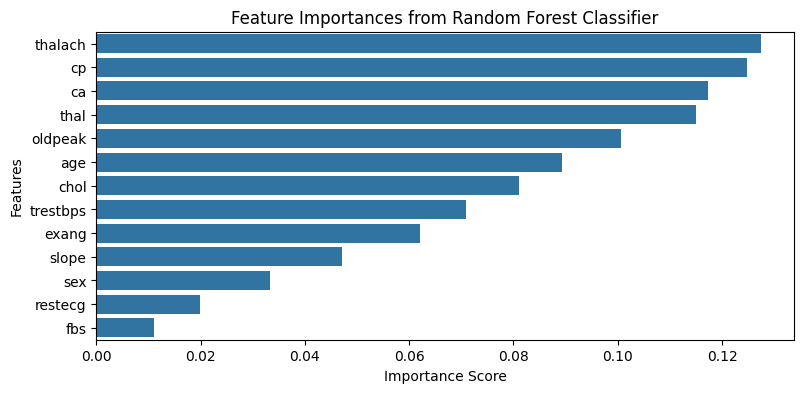

In [32]:
plt.figure(figsize=(9, 4))
sns.barplot(x=feature_importances.sort_values(ascending=False), y=feature_importances.sort_values(ascending=False).index)
plt.title("Feature Importances from Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

### Recursive Feature Elimination (RFE)

In [33]:
lr_model = LogisticRegression(max_iter=2000, random_state=42)

In [34]:
rfe = RFE(estimator=lr_model, n_features_to_select=6)
rfe.fit(X, Y)

,estimator,LogisticRegre...ndom_state=42)
,n_features_to_select,6
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [35]:
selected_rfe_features = X.columns[rfe.support_]
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns)

In [36]:
print("Features ranking from RFE:")
print(rfe_ranking.sort_values())

Features ranking from RFE:
sex         1
cp          1
fbs         1
exang       1
slope       1
ca          1
oldpeak     2
thal        3
restecg     4
trestbps    5
thalach     6
age         7
chol        8
dtype: int64


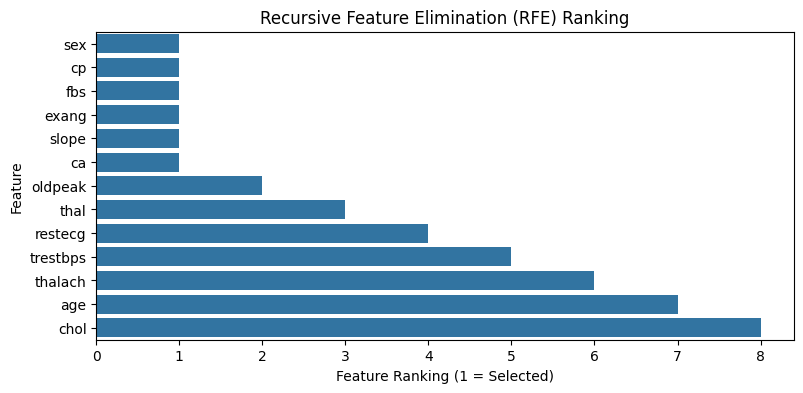

In [37]:
plt.figure(figsize=(9, 4))
sns.barplot(x=rfe_ranking.sort_values(), y=rfe_ranking.sort_values().index)
# sns.barplot(x=, y=rfe.ranking_.sort_values().index)
plt.title("Recursive Feature Elimination (RFE) Ranking")
plt.xlabel("Feature Ranking (1 = Selected)")
plt.ylabel("Feature")
plt.show()

In [38]:
print("Selected features using RFE:")
print(selected_rfe_features)

Selected features using RFE:
Index(['sex', 'cp', 'fbs', 'exang', 'slope', 'ca'], dtype='object')


### Chi-Square Test for Feature Significance

In [39]:
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [40]:
# discretize continuous features only
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_discretized = discretizer.fit_transform(X[continuous_features])
X_discretized = pd.DataFrame(X_discretized, columns=continuous_features)

In [41]:
X_combined = pd.concat([X_discretized, X[categorical_features]], axis=1)

In [42]:
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_combined, Y)

,score_func,<function chi2 at 0x15cfce700>
,k,'all'


In [43]:
chi2_scores = pd.Series(chi2_selector.scores_, index=X_combined.columns)
chi2_pvalues = pd.Series(chi2_selector.pvalues_, index=X_combined.columns)

In [44]:
print("Chi-Square Test Results:")
print("Chi2 Scores (higher is better):")
print(chi2_scores.sort_values(ascending=False))
print('-----------------------------------')
print("P-values (lower is better):")
print(chi2_pvalues.sort_values())

Chi-Square Test Results:
Chi2 Scores (higher is better):
ca          84.115181
thal        65.482313
oldpeak     57.139532
exang       38.052613
cp          15.140160
thalach     15.097546
restecg      8.644897
slope        8.243914
sex          7.432845
age          6.298123
trestbps     3.215230
chol         0.469073
fbs          0.164669
dtype: float64
-----------------------------------
P-values (lower is better):
ca          4.667726e-20
thal        5.863786e-16
oldpeak     4.059628e-14
exang       6.886243e-10
cp          9.981719e-05
thalach     1.020960e-04
restecg     3.279787e-03
slope       4.088886e-03
sex         6.404399e-03
age         1.208659e-02
trestbps    7.295596e-02
chol        4.934138e-01
fbs         6.848935e-01
dtype: float64


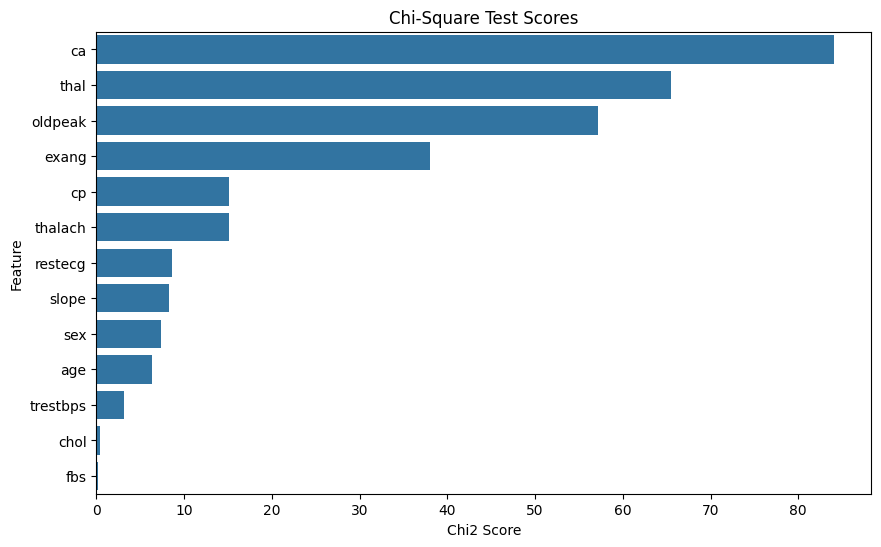

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x=chi2_scores.sort_values(ascending=False), y=chi2_scores.sort_values(ascending=False).index)
plt.title("Chi-Square Test Scores")
plt.xlabel("Chi2 Score")
plt.ylabel("Feature")
plt.show()

### Comparison of All Three Methods

In [46]:
print('Final Comparison of Feature Selection Methods')
print('-----------------------------------------------')
print('1. Top 6 Features from Random Forest:')
print(feature_importances.sort_values(ascending=False).head(6))
print('-----------------------------------------------')
print("2. Features Selected by RFE (Ranking = 1):")
print(selected_rfe_features.tolist())
print('-----------------------------------------------')
print("3. Top 5 Features from Chi-Square Test:")
print(chi2_scores.sort_values(ascending=False).head(6))
print('-----------------------------------------------')


Final Comparison of Feature Selection Methods
-----------------------------------------------
1. Top 6 Features from Random Forest:
thalach    0.127391
cp         0.124785
ca         0.117404
thal       0.114945
oldpeak    0.100558
age        0.089233
dtype: float64
-----------------------------------------------
2. Features Selected by RFE (Ranking = 1):
['sex', 'cp', 'fbs', 'exang', 'slope', 'ca']
-----------------------------------------------
3. Top 5 Features from Chi-Square Test:
ca         84.115181
thal       65.482313
oldpeak    57.139532
exang      38.052613
cp         15.140160
thalach    15.097546
dtype: float64
-----------------------------------------------


### Select the Importance Features

In [47]:
final_selected_features = ['thalach', 'cp', 'ca', 'oldpeak', 'thal', 'exang']
X_selected_features = X[final_selected_features]

In [48]:
df_selected_features = X_selected_features.copy()
df_selected_features['num'] = Y

In [49]:
print("Final selected features:")
df_selected_features.head()

Final selected features:


,thalach,cp,ca,oldpeak,thal,exang,num
0,150,1,0.0,2.3,6.0,0,0
1,108,4,3.0,1.5,3.0,1,1
2,129,4,2.0,2.6,7.0,1,1
3,187,3,0.0,3.5,3.0,0,0
4,172,2,0.0,1.4,3.0,0,0


In [50]:
df_selected_features.to_csv("../data/feature_selection_heart_disease.csv", index=False)
print("\nFinal reduced dataset saved to '../data/feature_selection_heart_disease.csv'")


Final reduced dataset saved to '../data/feature_selection_heart_disease.csv'
